# Binary Classification of Speech Data

Classifiying US Congressional Speech (text) data into two clusters/groups representing "For" vs "Against" debate.

In [151]:
# Importing the libraries
import pandas as pd
from pandas.tools.plotting import parallel_coordinates
import numpy as np
import sklearn 
import scipy.sparse as sp
%matplotlib inline  
# Don't use plt.show() as it opens a new window and blocks the evaluation of cell. 
import matplotlib.pyplot as plt

In [152]:
# Changing the default data frame options. 
pd.set_option("max_r",3000) # Set the default rows to 80
pd.set_option("max_columns",51000) # Set the default columns to 500 from 20. 
pd.set_option("expand_frame_repr",False) # Checks if frame can be expanded or truncated. Make it expand column-wise
np.set_printoptions(threshold=np.inf) # Removes the threshold level to print numpy array
np.set_printoptions(suppress=True) # Prevents printing scientific notation

In [177]:
# Creating a class to run various clustering algorithms on this data. 

"""This class has methods for various clustering algorithms used to do cluster (Binary classification) 
on the dataset
i) spectralClust-> Does Spectral Clustering of the graph/adjacency matrix of speech text
ii) kMeans-> Performs kMeans clustering of points
iii) LDA-> Carrying out Latent Dirichlet Allocation of text data
iv) NNMF-> Non Negative Matrix Factorization method to finding hidden concepts
"""

class clf(object):
    """This class takes in a dataset and runs various classification 
    algorithms on it
    """
    
    def __init__(self,d=8):
        """Consructor to intialise the attributes"""
        #self.k=k  # Assigning k for Kfold cross-validation
        self.file1="speech_vecs.npz"
        self.d=d
        
        
    def preProc(self):
        """Reading the dataset and taking out the 8 label observations
        """
        loader = np.load(self.file1)
        self.speech_vectors =sp.csr_matrix(( loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])
        self.speech_graph = np.loadtxt('speech_graph.csv', delimiter=',')
        
        
        
    def spectral(self):
        """ Trying the Spectral clustering on this data"""
        # Creating an empty Diagonal Matrix
        W=self.speech_graph
        D=np.zeros((len(W),len(W)))
        # Creating an Identity Matrix of NxN size
        I=np.eye(len(W),dtype=float)
        
        # Summing the elements of each row(Finding the total degrees of each node)
        for x in range(len(W)):
            D[x][x]=np.sum(W[x])
        # Finding the negative square root of Diagonal Matrix. 
        Dinv=np.zeros(D.shape)
        np.fill_diagonal(Dinv,1/(D.diagonal()**0.5))
        # Finding the normalised Laplacian Matrix
        L=I-(np.dot(Dinv,W).dot(Dinv))
        # Finding the eigen decomposition of Laplacian Matrix
        e_vals,e_vec=np.linalg.eig(L)
        # Retaining the first two smallest eigenvectors of e_vec. Those are the embeddings of Spectral. (Yis)
        min_e=e_vals.argsort()[0:self.d]
        self.Y=e_vec[:,min_e]
        
        
         
    def LDA(self):
        """This method implements Latent Dirichlet Allocation on text data"""
        
        import gensim
        self.corpus = gensim.matutils.Sparse2Corpus(self.speech_vectors,documents_columns=False)
        self.lda=gensim.models.ldamodel.LdaModel(self.corpus, num_topics=38,iterations=300,passes=10,update_every=1,alpha=50/38,eta=0.01)
        doc=self.lda[self.corpus]
        
        self.doc_topic=np.zeros((2740,38))
        index=0
        l=[]
        for x in doc:
            for y in range(38):
                self.doc_topic[index,y]=x[y][1]
            index+=1
        
        
        
    def LDA_25K(self):
        """This method implements Latent Dirichlet Allocation on only the last 25K features data"""
        
        import gensim
        self.speech_vectors_25K=self.speech_vectors[:,25000:].toarray() # Stripping first 25K features
        corpus = gensim.matutils.Dense2Corpus(self.speech_vectors_25K,documents_columns=False)
        #self.corpus = gensim.matutils.Sparse2Corpus(self.speech_vectors,documents_columns=False)
        self.lda=gensim.models.ldamodel.LdaModel(corpus, num_topics=38,iterations=300,passes=10,update_every=1,alpha=50/38,eta=0.01)
        self.doc=self.lda[corpus]
        
        self.doc_topic=np.zeros((2740,38))
        index=0
        for x in self.doc:
            for y in range(38):
                self.doc_topic[index,y]=x[y][1]
            index+=1
                    
        
    def NMF(self): 
        """This method implments Non-Negative Matrix Factorization"""
        from sklearn.decomposition import ProjectedGradientNMF
        self.speech_vectors_25K=self.speech_vectors[:,25000:].toarray()
        model = ProjectedGradientNMF(n_components=38, init='nndsvd',random_state=1,max_iter=250)
        self.doc_topic=model.fit_transform(self.speech_vectors_25K)
        self.H=model.components_
        
        
        
    def kMeans(self):
        """Doing Kmeans on the dataset
        """
        # Importing the scikit-learn KMeans package
        from sklearn.cluster import KMeans
        # Choosing the initial centroid point from embeddings
        centroids = np.zeros((2,self.d))
        centroids[0,:] = np.mean(self.Y[[2,13,18,24]],axis=0) # centroid 1
        centroids[1,:] = np.mean(self.Y[[1,3,27,177]],axis=0) # centroid 2
        kmeans=KMeans(n_clusters=2,init=centroids,n_init=1, max_iter=20)
        kmeans.fit(self.Y)
        self.Y_transformed=kmeans.transform(self.Y)
        self.clusters=kmeans.labels_
        
    
        
# Defining the function to create objects 
def runClass(obj,estimator="spectral",problem=1):
    """ This function creates a Class object and runs multiple methods present there
    """
    obj.preProc() # Calling the preprocessing method
    if (problem==1):
        obj.spectral()
        obj.kMeans()
    elif(estimator=="LDA"):
        obj.LDA()
        obj.kMeans2()
    else:
        obj.NNMF()
        obj.kMeans2()
    return obj.clusters

In [178]:
if __name__=="__main__":
    # Creating Object d as argument. 
    d=10 # Dimensions of embedding one wants to project the intial points.
    obj=clf(d)
    clusters=runClass(obj)
    e=np.zeros((2740,2),dtype=int)
    e[:,0]=range(0,len(obj.clusters))
    e[:,1]=obj.clusters
    #np.savetxt("votes.csv", e, delimiter=",", fmt="%d") # saving the file as csv.
    

# Visualizing the 10 dimensional Spectral embeddings in 2D

Using Parallel Co-ordinates for visualization

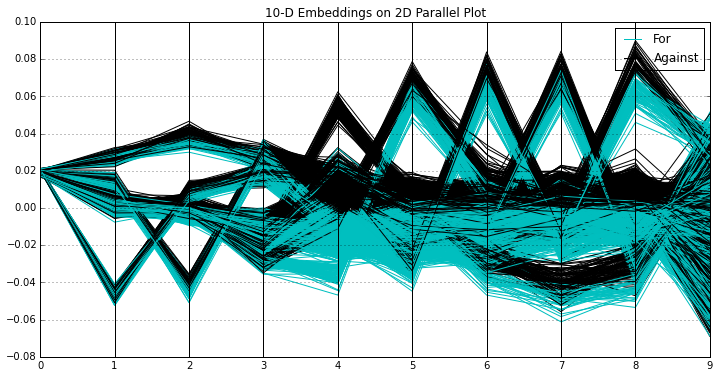

In [196]:
# Converting the embeddings data as a pandas dataframe
Y_embed=pd.DataFrame(obj.Y)
#pd.concat([Y_embed, obj.clusters], axis=1)
Y_embed['Cluster']=["For" if c else "Against" for c in obj.clusters]
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.title("10-D Embeddings on 2D Parallel Plot")
parallel_coordinates(Y_embed,'Cluster',color=['c','k'])

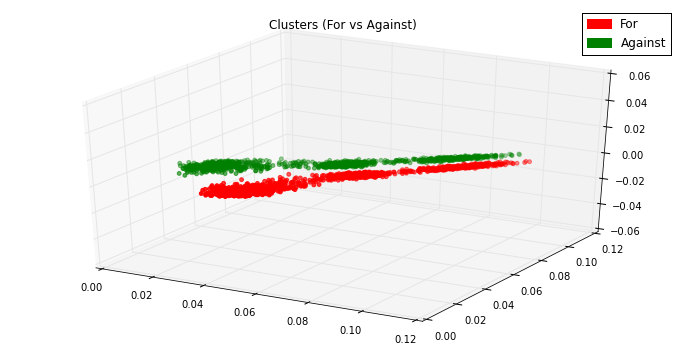

In [193]:
# Visualizing the resulting two clusters. 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(12, 6), dpi=100)
ax = fig.add_subplot(111, projection='3d')
red_patch = mpatches.Patch(color='red', label='For')
green_patch = mpatches.Patch(color='green', label='Against')
plt.legend(handles=[red_patch,green_patch])
ax.scatter(obj.Y_transformed[:,0],obj.Y_transformed[:,1],color=["r" if c else "g" for c in obj.clusters],s=15)
plt.title("Clusters (For vs Against)")

# II).  Multiclass Classification

This part is classification of all the speeches made in US Congressional hearing into different
debates they were part of. Essentially finding all the groups of debates. 

In [197]:
# Running Latent Dirichlet Allocation 

In [199]:
if __name__=="__main__":
    # Creating Object d as argument. 
    obj=binaryClf()
    obj.preProc()
    obj.LDA()

In [ ]:
# LDA Output 
debates=np.zeros((2740,2))
index=range(2740)
debates[:,0]=index
debates[:,1]=obj.clusters
np.savetxt("debates_LDA.csv", debates, delimiter=",", fmt="%d")

In [198]:
# Non Negative Matrix Factorization 
obj1=binaryClf()
obj1.preProc()
obj1.NMF()


In [80]:
clusters=kmeans3(obj.doc_topic)

In [45]:
# NMF output 
d=np.zeros((2740,2))
index=range(2740)
d[:,0]=index
d[:,1]=np.argmax(obj1.doc_topic,axis=1)
np.savetxt("debates_NMF.csv", d, delimiter=",", fmt="%d")

In [82]:
# LDA Output 
debates=np.zeros((2740,2))
index=range(2740)
debates[:,0]=index
debates[:,1]=clusters
np.savetxt("debates_LDA_25K.csv", debates, delimiter=",", fmt="%d")